In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from gensim.models import KeyedVectors
import gensim


In [2]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

# Display first few rows to understand the data
train_data.head()

,Sentence_id,Text,Verdict
0,1,I think we've seen a deterioration of values.,-1
1,2,I think for a while as a nation we condoned th...,-1
2,3,"For a while, as I recall, it even seems to me ...",-1
3,4,"So we've seen a deterioration in values, and o...",-1
4,5,"We got away, we got into this feeling that val...",-1


In [3]:
word2vec_model = KeyedVectors.load_word2vec_format('/Users/anc/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)


In [4]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(train_data['Text'][0])

In [5]:
[t.lemma_ for t in doc]

['I', 'think', 'we', 'have', 'see', 'a', 'deterioration', 'of', 'value', '.']

In [6]:

train_data['text_clean'] = train_data['Text'].apply(lambda x: [t.lemma_ for t in nlp(x)])
train_data.head()

,Sentence_id,Text,Verdict,text_clean
0,1,I think we've seen a deterioration of values.,-1,"[I, think, we, have, see, a, deterioration, of..."
1,2,I think for a while as a nation we condoned th...,-1,"[I, think, for, a, while, as, a, nation, we, c..."
2,3,"For a while, as I recall, it even seems to me ...",-1,"[for, a, while, ,, as, I, recall, ,, it, even,..."
3,4,"So we've seen a deterioration in values, and o...",-1,"[so, we, have, see, a, deterioration, in, valu..."
4,5,"We got away, we got into this feeling that val...",-1,"[we, get, away, ,, we, get, into, this, feelin..."


In [26]:
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 1))
vectorizer.fit(train_data['Text'])
word2tfidf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))


In [27]:
from typing import List


def sentence_to_vec(tokens: List[str], word2vec, word2tfidf, vector_size=300):
    word_vectors = [word2vec[word] * word2tfidf.get(word, 1) for word in tokens if word in word2vec]

    if not word_vectors:
        return np.zeros(vector_size)
    
    # Return average of all word word_vectors in the sentence
    return np.mean(word_vectors, axis=0)

In [41]:
# Split data into features and target
X = train_data['text_clean']
y = train_data['Verdict']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_val.shape)

Train shape: (18000,) Test shape: (4501,)


In [42]:
print("Converting sentences to vectors...")
X_train_vectors = np.array([sentence_to_vec(sentence, word2vec_model, word2tfidf) for sentence in X_train])
X_val_vectors = np.array([sentence_to_vec(sentence, word2vec_model, word2tfidf) for sentence in X_val])

print("X_train_vectors shape:", X_train_vectors.shape, "\nX_val_vectors shape:", X_val_vectors.shape)

Converting sentences to vectors...
X_train_vectors shape: (18000, 300) 
X_val_vectors shape: (4501, 300)


In [89]:
import string


nlp = spacy.load("en_core_web_sm")
class SyntacticFeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for text in X:
            doc = nlp(text)
            # Feature 1: Sentence length (number of tokens)
            sentence_length = len(doc)
            # Feature 2: Punctuation ratio
            punctuation_ratio = sum(1 for token in doc if token.text in string.punctuation)/ sentence_length
            # Feature 3: ratio of nouns, verbs, adjectives
            noun_ratio = sum(1 for token in doc if token.pos_ == "NOUN")/ sentence_length
            verb_ratio = sum(1 for token in doc if token.pos_ == "VERB")/ sentence_length
            adj_ratio = sum(1 for token in doc if token.pos_ == "ADJ")/ sentence_length
            # Feature 4: ratio of stopwords
            stopword_ratio = sum(token.is_stop for token in doc) / sentence_length

            features.append([sentence_length, punctuation_ratio, noun_ratio, verb_ratio, adj_ratio, stopword_ratio])
        return np.array(features)

# Custom transformer to extract named entity features
class NamedEntityFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.entity_types = ['PERSON', 'ORG', 'GPE', 'DATE', 'MONEY', 'CARDINAL', 'NORP', 'PERCENT']
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for text in X:
            doc = nlp(text)
            # Total number of entities in the sentence
            total_entities = len(doc.ents)
            # Count of specific entity types
            type_counts = {etype: 0 for etype in self.entity_types}
            for ent in doc.ents:
                if ent.label_ in type_counts:
                    type_counts[ent.label_] += 1
            # Combine features: total entities + counts for each type
            feature_row = [total_entities] + [type_counts[etype] for etype in self.entity_types]
            features.append(feature_row)
        return np.array(features)

# Combine TF-IDF features with syntactic and named entity features
combined_features = FeatureUnion([
    ('syntactic', SyntacticFeaturesExtractor()),
    ('entities', NamedEntityFeaturesExtractor())
])

X_train_custom_features = combined_features.fit_transform(X_train.apply(lambda x: ' '.join(x)))
X_val_custom_features = combined_features.transform(X_val.apply(lambda x: ' '.join(x)))

In [90]:
X_train_combined = np.hstack((X_train_vectors, X_train_custom_features))
X_val_combined = np.hstack((X_val_vectors, X_val_custom_features))


In [91]:
X_train_combined.shape

(18000, 315)

In [92]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_vectors_oversampled, y_train_oversampled = smote.fit_resample(X_train_combined, y_train)
smote_class_counts = y_train_oversampled.value_counts().sort_index()
print(f"Class -1: {smote_class_counts.get(-1, 0)} samples")
print(f"Class 0: {smote_class_counts.get(0, 0)} samples")
print(f"Class 1: {smote_class_counts.get(1, 0)} samples")

Class -1: 11759 samples
Class 0: 11759 samples
Class 1: 11759 samples


In [93]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# X_train_str = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_train]
# X_val_str = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_val]

# # Assuming X_train and X_val are lists of text data
# tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))  # Adjust max_features as needed
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str).toarray()
# X_val_tfidf = tfidf_vectorizer.transform(X_val_str).toarray()

# import numpy as np

# # Assuming X_train_vect_avg and X_val_vect_avg are the word2vec embeddings
# X_train_combined = np.hstack((X_train_vect_avg, X_train_tfidf))
# X_val_combined = np.hstack((X_val_vect_avg, X_val_tfidf))

In [94]:
# X_train_combined.shape, X_val_combined.shape

In [112]:
import torch
from torch.utils.data import Dataset, DataLoader


class FactDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels) if labels is not None else None
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        return self.features[idx]
    
train_dataset = FactDataset(X_train_combined, np.array(y_train) + 1)
val_dataset = FactDataset(X_val_combined, np.array(y_val) + 1)
# test_dataset = FactDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
# test_loader = DataLoader(test_dataset, batch_size=32)

## Neural network

In [113]:
from skorch import NeuralNetClassifier
import torch.nn as nn
import torch.nn.functional as F
import torch

# Define your PyTorch model.
class SimpleNN(nn.Module):
    def __init__(self, input_dim=315, hidden_dim1=128, hidden_dim2=64, num_classes=3, dropout_rate=0.4):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout = nn.Dropout(dropout_rate)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.bn1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.bn2(x)

        x = self.fc3(x)
        return x

In [131]:
import copy
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = SimpleNN().to(device)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.FloatTensor(class_weights).to(device)

# Update your loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.01, weight=class_weights)
# criterion = FocalLoss(alpha=class_weights, gamma=2.0)

optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

# Print model summary
print(model)

num_epochs = 30
train_losses = []
val_losses = []
train_accs = []
val_f1s = []

best_val_f1 = 0
best_model_state = None
patience = 5
counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Calculate accuracy by class
    train_report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    train_acc = train_report['macro avg']['f1-score']  # Use F1 score instead of accuracy
    train_accs.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)
    
    # Calculate validation metrics
    val_report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)
    val_f1 = val_report['macro avg']['f1-score']  # Use F1 score
    val_f1s.append(val_f1)
    
    print('---------------------------------------------')
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train F1: {train_acc:.4f}')
    print(f'Val Loss: {val_epoch_loss:.4f} | Val F1: {val_f1:.4f}')
    print('Validation performance by class:')
    for cls in sorted(val_report.keys()):
        if cls in ['0', '1', '2']:  # Classes in numerical form
            print(f"Class {int(cls)-1}: F1={val_report[cls]['f1-score']:.4f}, Precision={val_report[cls]['precision']:.4f}, Recall={val_report[cls]['recall']:.4f}")
    
    # Update learning rate based on validation loss
    scheduler.step(val_epoch_loss)
    
    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = copy.deepcopy(model.state_dict())
        print('saving model state')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break

# Load the best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded the best model state")

Using device: mps
SimpleNN(
  (fc1): Linear(in_features=315, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


/Users/anc/Library/CloudStorage/OneDrive-Personal/Desktop/NUS/Modules/Y4S2/CS4248/A2/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


---------------------------------------------
Epoch 1/30 | Train Loss: 1.1675 | Train F1: 0.3049
Val Loss: 1.0930 | Val F1: 0.2846
Validation performance by class:
Class -1: F1=0.2361, Precision=0.8392, Recall=0.1374
Class 0: F1=0.1910, Precision=0.1123, Recall=0.6394
Class 1: F1=0.4267, Precision=0.4101, Recall=0.4445
saving model state
---------------------------------------------
Epoch 2/30 | Train Loss: 1.0950 | Train F1: 0.3714
Val Loss: 1.0412 | Val F1: 0.3890
Validation performance by class:
Class -1: F1=0.4288, Precision=0.9014, Recall=0.2813
Class 0: F1=0.2151, Precision=0.1316, Recall=0.5876
Class 1: F1=0.5231, Precision=0.4699, Recall=0.5899
saving model state
---------------------------------------------
Epoch 3/30 | Train Loss: 1.0397 | Train F1: 0.4258
Val Loss: 0.9799 | Val F1: 0.4700
Validation performance by class:
Class -1: F1=0.5958, Precision=0.8987, Recall=0.4457
Class 0: F1=0.2603, Precision=0.1683, Recall=0.5737
Class 1: F1=0.5539, Precision=0.4989, Recall=0.6226

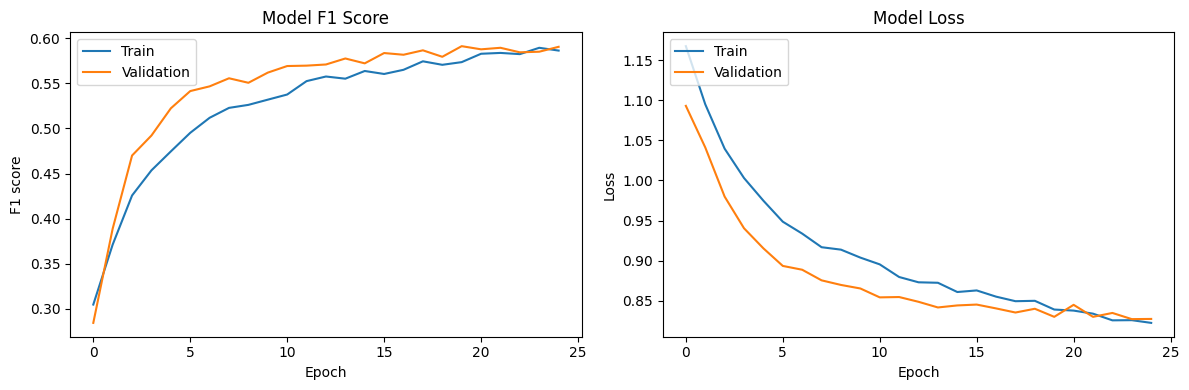

In [133]:
# Visualize training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs)
plt.plot(val_f1s)
plt.title('Model F1 Score')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()


In [134]:
# Evaluate the model on the test set
model.load_state_dict(best_model_state)
model.eval()
val_loss = 0.0
val_preds = []
val_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())


# Calculate validation metrics
val_report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)
print('Validation performance by class:')
for class_name, metrics in val_report.items():
    print(f'{class_name}: {metrics}')

Validation performance by class:
0: {'precision': 0.8879310344827587, 'recall': 0.6688311688311688, 'f1-score': 0.762962962962963, 'support': 2926.0}
1: {'precision': 0.28857715430861725, 'recall': 0.5737051792828686, 'f1-score': 0.384, 'support': 502.0}
2: {'precision': 0.5719784449576597, 'recall': 0.6924510717614166, 'f1-score': 0.6264755480607083, 'support': 1073.0}
accuracy: 0.6638524772272828
macro avg: {'precision': 0.5828288779163452, 'recall': 0.6449958066251513, 'f1-score': 0.5911461703412237, 'support': 4501.0}
weighted avg: {'precision': 0.7457642323481553, 'recall': 0.6638524772272828, 'f1-score': 0.6881594962672228, 'support': 4501.0}


Confusion matrix saved as 'confusion_matrix.png'


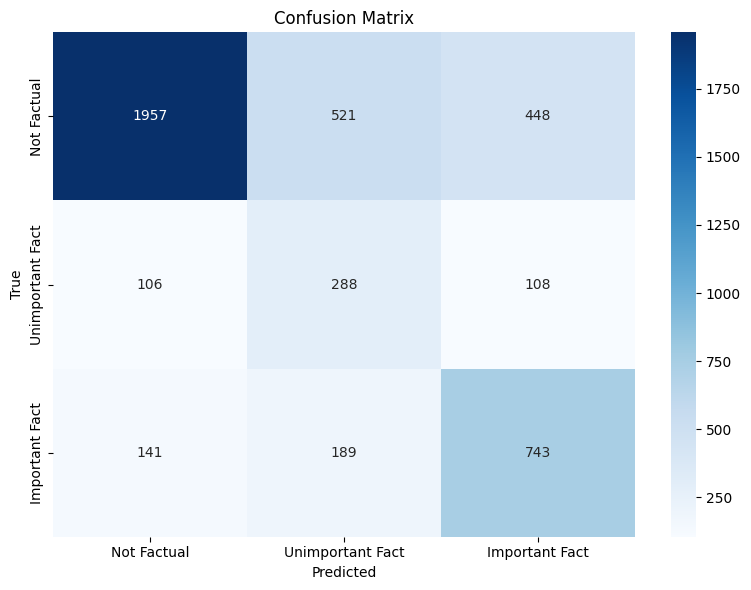

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create and plot confusion matrix
cm = confusion_matrix(y_val, np.array(val_preds) - 1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [136]:
test_df = pd.read_csv('data/test.csv')
test_df['text_clean'] = test_df['Text'].apply(lambda x: [t.lemma_ for t in nlp(x)])
X_test = test_df['text_clean']
X_test_vectors = np.array([sentence_to_vec(sentence, word2vec_model, word2tfidf) for sentence in X_test])
X_test_custom_features = combined_features.transform(X_test.apply(lambda x: ' '.join(x)))
X_test_combined = np.hstack((X_test_vectors, X_test_custom_features))


test_dataset = FactDataset(X_test_combined)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [145]:
# Evaluate the model on the test set
model.load_state_dict(best_model_state)
model.eval()
test_preds = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())



output_df = pd.DataFrame({
    'Sentence_id': test_df['Sentence_id'],
    'Verdict': np.array(test_preds) - 1
})

output_path = 'data/tfidf_word2vec_features_nn_predictions.csv'
# Save to CSV
output_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to data/tfidf_word2vec_features_nn_predictions.csv


## Random forest

In [81]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_combined, y_train.values.ravel())

In [82]:

y_pred = rf_model.predict(X_val_combined)


validation_accuracy = accuracy_score(y_val, y_pred)
validation_f1_macro = f1_score(y_val, y_pred, average='macro')
validation_f1_per_class = f1_score(y_val, y_pred, average=None)

# Print metrics
print("\nValidation set performance:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"Macro F1 Score: {validation_f1_macro:.4f}")
print(f"F1 Score per class:")
for i, score in enumerate(validation_f1_per_class):
    class_label = {-1: "Not Factual", 0: "Unimportant Fact", 1: "Important Fact"}.get(i-1, f"Class {i-1}")
    print(f"  {class_label}: {score:.4f}")



Validation set performance:
              precision    recall  f1-score   support

          -1       0.77      0.91      0.83      2926
           0       0.48      0.02      0.05       502
           1       0.54      0.52      0.53      1073

    accuracy                           0.71      4501
   macro avg       0.60      0.48      0.47      4501
weighted avg       0.68      0.71      0.67      4501

Accuracy: 0.7141
Macro F1 Score: 0.4682
F1 Score per class:
  Not Factual: 0.8296
  Unimportant Fact: 0.0455
  Important Fact: 0.5294


Confusion matrix saved as 'confusion_matrix.png'


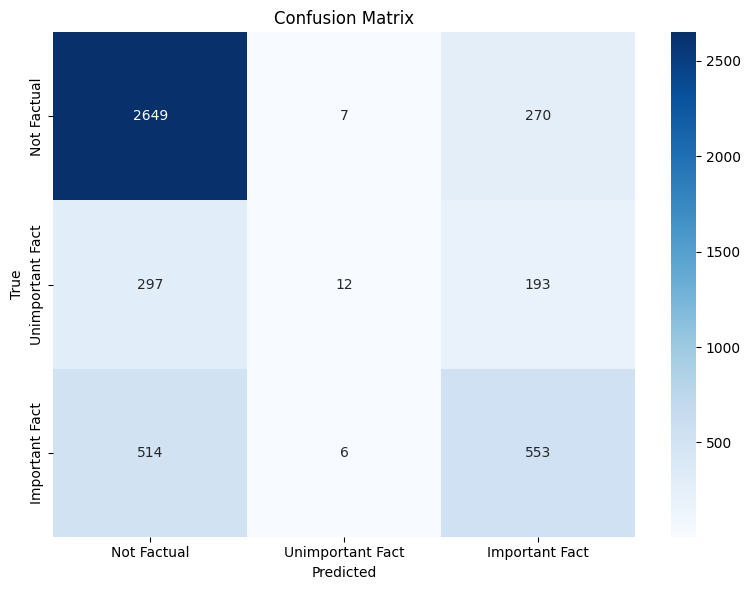

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create and plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression


y_train_mapped = y_train_oversampled.values + 1
y_val_mapped = y_val.values + 1

logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train_vectors_oversampled, y_train_mapped)

LogisticRegression(class_weight='balanced', max_iter=1500)

Accuracy on the validation set: 67.01%
Macro F1 Score: 0.5929
F1 Score per class: [0.76878834 0.38253638 0.62740077]
Confusion matrix saved as 'confusion_matrix.png'


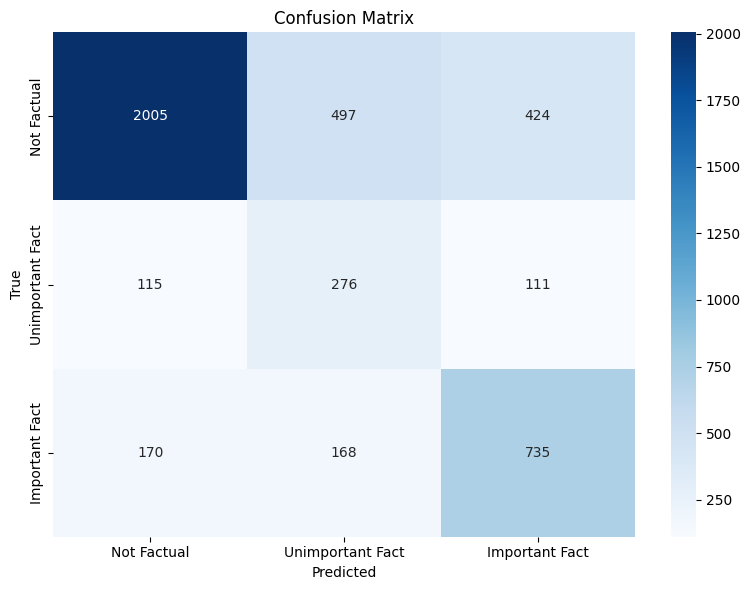

In [104]:
y_val_pred = logreg.predict(X_val_combined)

# Evaluate the model
accuracy = accuracy_score(y_val_mapped, y_val_pred)
f1 = f1_score(y_val_mapped, y_val_pred, average='macro')
f1_per_class = f1_score(y_val_mapped, y_val_pred, average=None)

print(f'Accuracy on the validation set: {accuracy * 100:.2f}%')
print(f'Macro F1 Score: {f1:.4f}')
print(f'F1 Score per class: {f1_per_class}')

# Create and plot confusion matrix
cm = confusion_matrix(y_val_mapped, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [87]:
# Save the model
joblib.dump(logreg, 'logreg.pkl')
print("Model saved as 'logreg.pkl'")
model = joblib.load('logreg.pkl')

Model saved as 'logreg.pkl'


In [147]:
output_df = pd.DataFrame({
    'Sentence_id': test_df['Sentence_id'],
    'Verdict': logreg.predict(X_test_combined) - 1
})

output_path = 'data/tfidf_word2vec_features_lr_predictions.csv'
# Save to CSV
output_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")


Predictions saved to data/tfidf_word2vec_features_lr_predictions.csv


In [90]:

# Function to make predictions on test data
def predict_test_data(model_path, test_path, output_path):
    # Load the model and test data
    model = joblib.load(model_path)
    test_data = pd.read_csv(test_path)
    X_test = test_data['Text'].tolist()  # Assuming the text column is named 'text'

    # Preprocess the test data
    X_test_str = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_test]
    X_test_tfidf = tfidf_vectorizer.transform(X_test_str).toarray()

    # Convert sequences of word vectors to lists of tensors
    words = set(w2v_model.wv.index_to_key)
    X_test_vect = []
    for doc in X_test_str:
        word_vectors = [w2v_model.wv[i] for i in doc.split() if i in words]
        if len(word_vectors) > 0:
            X_test_vect.append(np.mean(word_vectors, axis=0))
        else:
            X_test_vect.append(np.zeros(100))  # Assuming word2vec vectors are of size 100

    # Combine TF-IDF features with word2vec embeddings
    X_test_vect = np.array(X_test_vect)
    X_test_combined = np.hstack((X_test_vect, X_test_tfidf))

    
    # Make predictions
    predictions = model.predict(X_test_combined)
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'Sentence_id': test_data['Sentence_id'],
        'Verdict': predictions - 1
    })
    
    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


print("\nMaking predictions on test data...")
predict_test_data('logreg.pkl', 'data/test.csv', 'data/logreg_predictions.csv')


Making predictions on test data...
Predictions saved to data/logreg_predictions.csv
